In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
table_ref = {}
for table_name in Base.classes.keys():
    table_ref[table_name] = Base.classes[table_name]

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

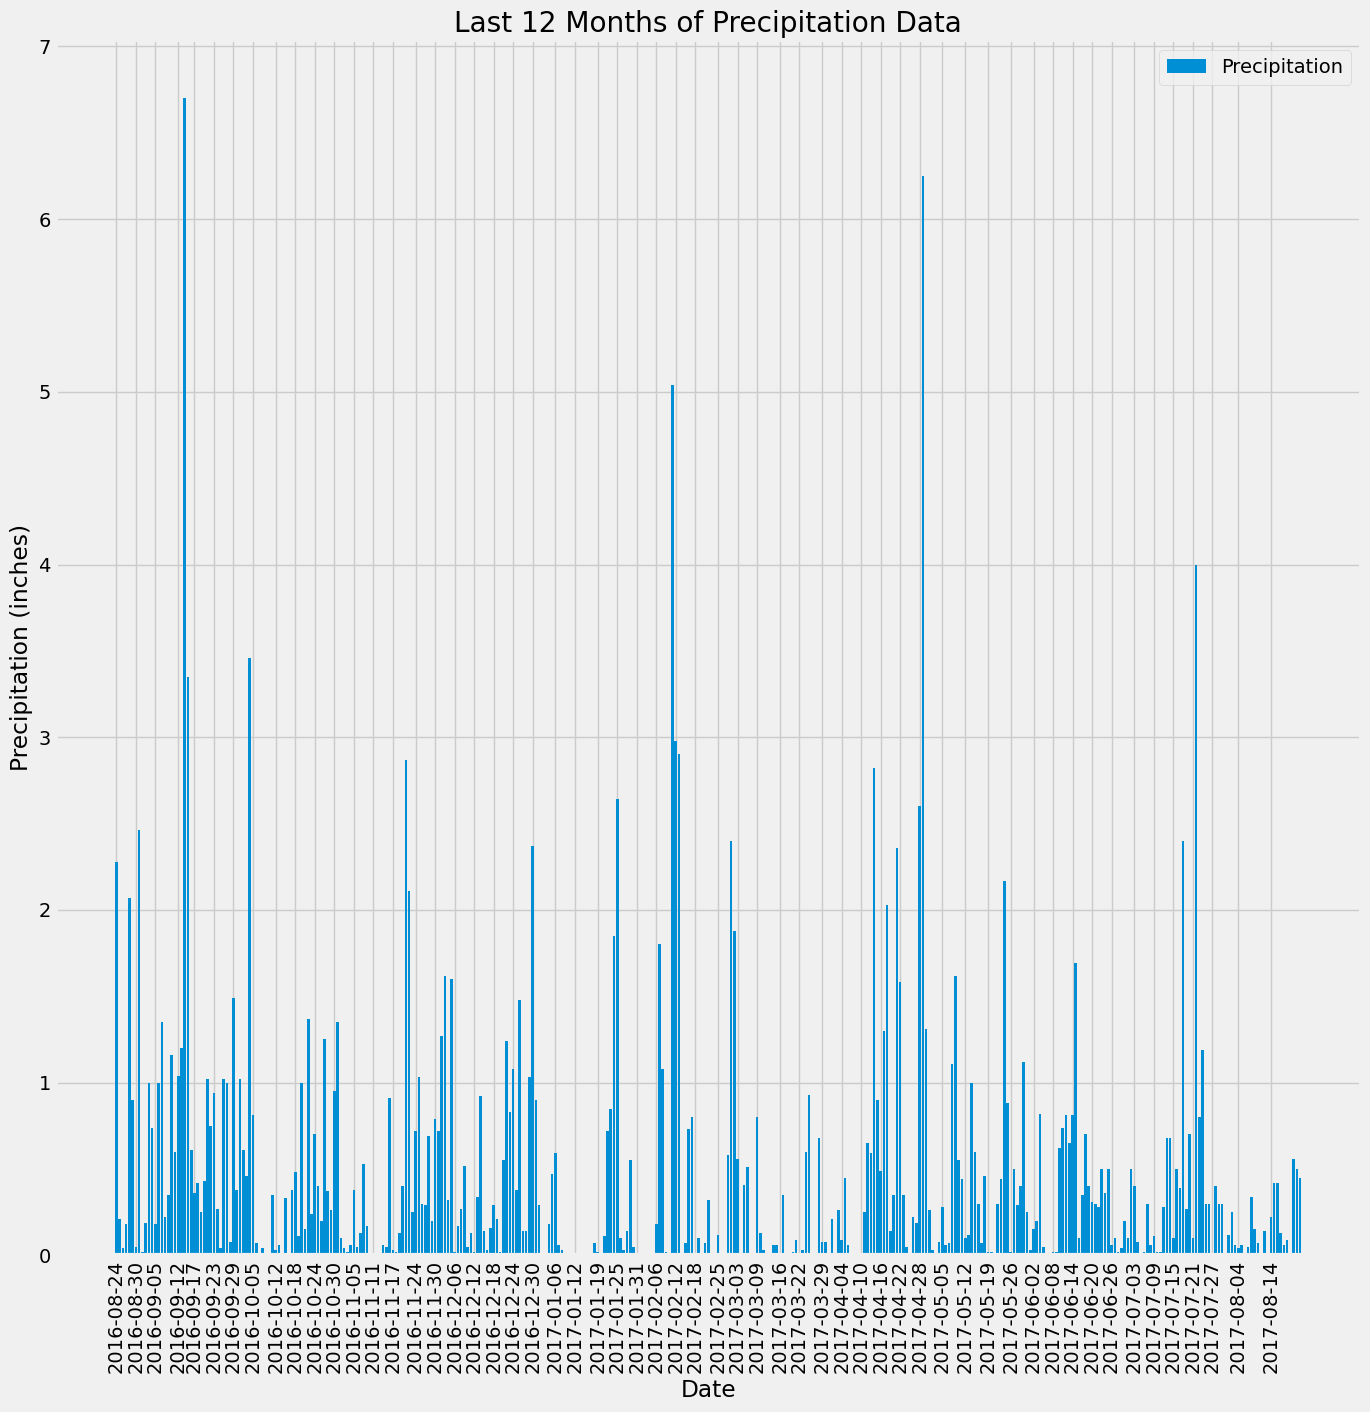

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row[0] if most_recent_date_row else None
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d') if most_recent_date else None
one_yr_ago = most_recent_date - timedelta(days=365) if most_recent_date else None

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_yr_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

one_year_precip_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
one_year_precip_df = one_year_precip_df.sort_values(by='Date')
#one_year_precip_df

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15, 15))
plt.bar(one_year_precip_df['Date'], one_year_precip_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=90)
every_nth = 39
plt.xticks(one_year_precip_df['Date'][::every_nth])
plt.legend()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = one_year_precip_df['Precipitation'].describe()
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
# total_stations = session.query(func.count(Station.station.distinct())).scalar()
# print(f'Total number of stations: {total_stations}')

len(session.query(Station.station).all())

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
most_active_station_id


temp_data = session.query(func.min(Measurement.tobs).label('min_temp'),
                         func.max(Measurement.tobs).label('max_temp'),
                         func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.station == most_active_station_id).first()

print(f'Most Active Station: {most_active_station_id}')
print(f'Lowest Temperature: {temp_data.min_temp}')
print(f'Highest Temperature: {temp_data.max_temp}')
print(f'Average Temperature: {temp_data.avg_temp}')

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


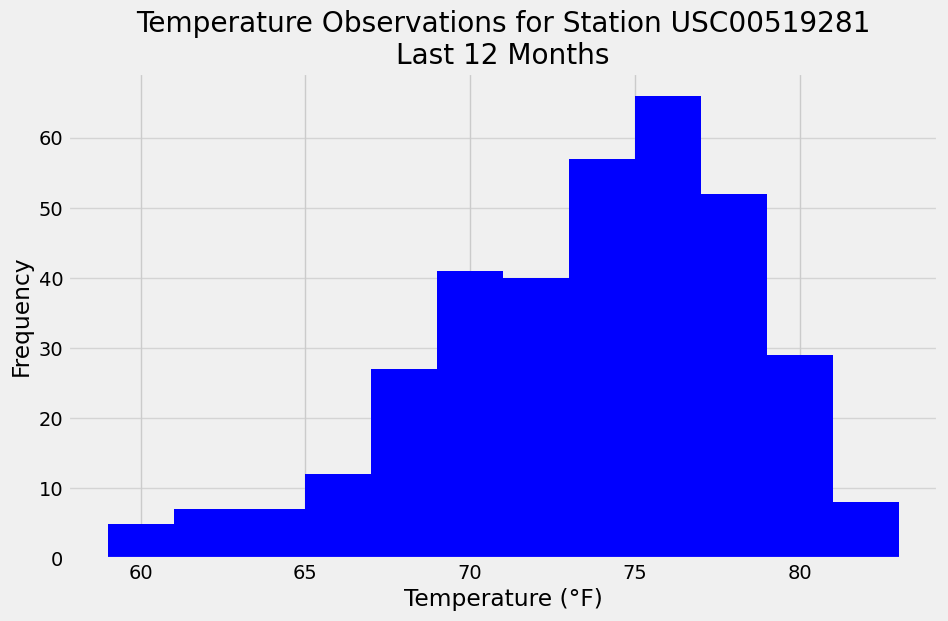

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
most_active_station_id

most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row[0] if most_recent_date_row else None
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') if most_recent_date_row else None
one_year_ago = most_recent_date - timedelta(days=365) if most_recent_date_row else None

twelve_mo_temp_data = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station_id).filter(Measurement.date >= one_year_ago).all())

temp_df = pd.DataFrame(twelve_mo_temp_data, columns=['Date', 'Temperature'])
temp_df['Date'] = pd.to_datetime(temp_df['Date'])

temp_df

#Plot Histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_df['Temperature'], bins=12, color='blue')
plt.title(f'Temperature Observations for Station {most_active_station_id}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [17]:
# Close Session
session.close()